# Pylops - sparse solvers for linear regression

This notebook concers with the solution a *multi-variate linear regression* problem:

$$y_i =  x_0 + \sum_{k=1}^{K-1} t_{k,i} x_k  \quad \forall i=1,2,...,N$$

where we assume that out of the $K$ coefficients only a handful of them is non-zero.

Here we can express our problem in a matrical form:

$$\mathbf{y}=  \mathbf{A} \mathbf{x}$$

where:

$$\mathbf{y}= [y_1, y_2,...,y_N]^T, \qquad \mathbf{x}= [x_0, x_1, , x_{K-1}]^T, \qquad \mathbf{A}= 
\begin{bmatrix}
    1 & t_{1, 1} & t_{2, 1} & ... & t_{K-1, 1} \\ 
    1 & t_{1, 2} & t_{2, 2} & ... & t_{K-1, 2} \\
    .. & ..     \\
    1  & t_{1, N} & t_{2, N} & ... & t_{K-1, N}
\end{bmatrix}$$

Since we know that only few coefficients are non-zero, we can encode this information in our cost function, penalizing the L1 norm of our solution (soft constraint):

$$J = ||\mathbf{y} - \mathbf{A} \mathbf{x}||_2 + \lambda ||\mathbf{x}||_1 $$

or alternatively adding an hard constraint to the problem:

$$J =  ||\mathbf{x}||_1  \quad subj. to \quad \mathbf{y}=  \mathbf{A} \mathbf{x}$$

First of all we will show that we can easily solve the first functional using an out-of-the-box nonlinear solver. 

While the first term in the cost function is a quadratic functional which could be solved by any linear solver (e.g., steepest descent, conjugate gradient), the presence of a L1 norm in the second term requires moving to nonlinear solvers.

We will then move on to using ad-hoc solvers that have been specifically developed for linear problems $\mathbf{y}=  \mathbf{A} \mathbf{x}$ with an additional L1 (soft or hard) constraint and see how out-of-the-box nonlinear solvers, which are generally great for full nonlinear problems (like optimizing the weights of a deep neural network) should not be favoured to more clever solvers when the problem at hand allow so.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from pylops.basicoperators import MatrixMult
from pylops.optimization.sparsity import FISTA, SPGL1
from pylops.utils import dottest

Let's create the forward problem

In [2]:
# parameters
order = 30
N = 51
x = np.zeros(order +1)
x[1] = 4
x[3] = 1
x[19] = 2

# set up problem
t = np.random.normal(0, 1, (N, order))
t = np.concatenate((np.ones((N, 1)), t), axis=1)
Lop = MatrixMult(t, dtype='float64')
dottest(Lop, N, order+1, verb=True)

y = Lop*x

Dot test passed, v^T(Opu)=-43.319610 - u^T(Op^Tv)=-43.319610


We first solve this problem with a linear least-squares solver, removing the L1 regularization term. 

Obviously because we have not added any noise to the solution, we can still retrieve the correct model. As notebook is mostly concerned with the computational cost of various methods, we will not add any noise to the data but the interested reader can also play with various levels of noise and compare the results when adding the L1 regularization term versur solving the least-squares cost function alone.

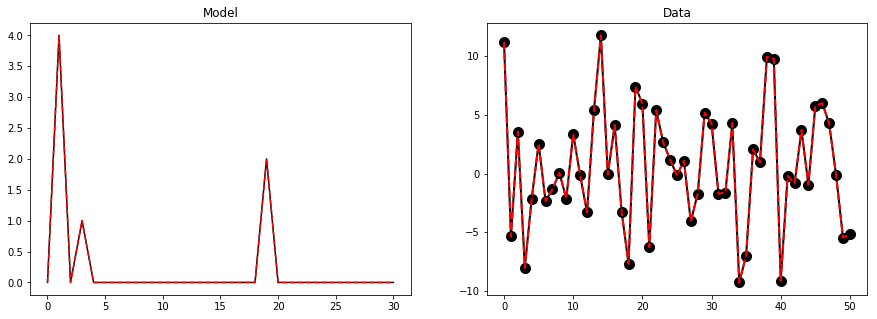

In [3]:
# LSQR solver
xlsqr, istop, itn, r1norm, r2norm = lsqr(Lop, y, damp=1e-10, iter_lim=100, show=0)[0:5]

# Apply
ylsqr = Lop * xlsqr

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(x, 'k', label='True')
axs[0].plot(xlsqr, '--r', label='Estimate')
axs[0].set_title('Model')

axs[1].plot(y, '.-k', ms=20, lw=2, label='True')
axs[1].plot(ylsqr, '--r', lw=2, label='Estimate')
axs[1].set_title('Data');

Let's now add the sparsity constraint and solve it with an out-of-the-box nonlinear solver

In [4]:
def fun(x, yobs, L, lam):
    y = np.dot(L, x)
    j = np.linalg.norm(yobs - y) + lam*np.linalg.norm(x, ord=1)
    return j

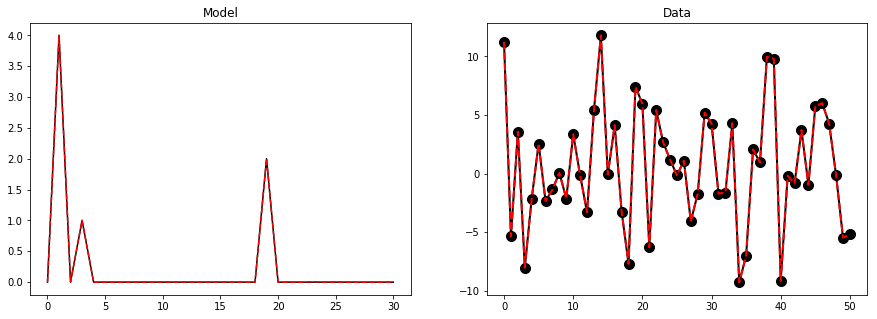

In [5]:
lam = .5
f = lambda x: fun(x, y, Lop.A, lam)
nl = minimize(f, np.zeros(order+1), method='L-BFGS-B', options=dict(maxiter=20)) # zero initial guess
#nl = minimize(f, np.random.normal(0, 2, order+1)) # random initial guess
xnl = nl.x
ynl = Lop * xnl

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(x, 'k', label='True')
axs[0].plot(xnl, '--r', label='Estimate')
axs[0].set_title('Model')

axs[1].plot(y, '.-k', ms=20, lw=2, label='True')
axs[1].plot(ynl, '--r', lw=2, label='Estimate')
axs[1].set_title('Data');

We can now do the same, but we at least try to help our nonlinear solver by providing the gradient which in our case is

$$\frac{dJ}{d\mathbf{x}} = 2 \mathbf{A}^T ( \mathbf{A} \mathbf{x} - \mathbf{y} ) + \lambda sign(\mathbf{x}) $$

In [6]:
def grad(x, yobs, L, lam):
    y = np.dot(L, x)
    grad = 2*np.dot(L.T, y - yobs) + lam*np.sign(x)
    return grad

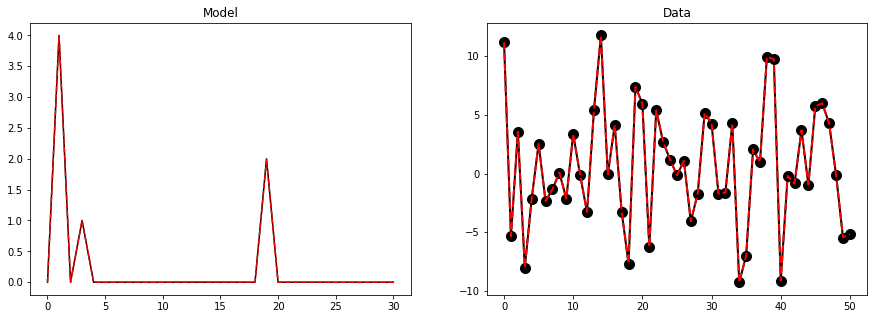

In [7]:
lam = 1.
f = lambda x: fun(x, y, Lop.A, lam)
g = lambda x: grad(x, y, Lop.A, lam)

nlg = minimize(f, np.zeros(order+1), jac=g, method='L-BFGS-B', options=dict(maxiter=15))
xnlg = nlg.x
ynlg = Lop * xnlg

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(x, 'k', label='True')
axs[0].plot(xnlg, '--r', label='Estimate')
axs[0].set_title('Model')

axs[1].plot(y, '.-k', ms=20, lw=2, label='True')
axs[1].plot(ynlg, '--r', lw=2, label='Estimate')
axs[1].set_title('Data');

We now use FISTA to solve the same problem with soft constraint

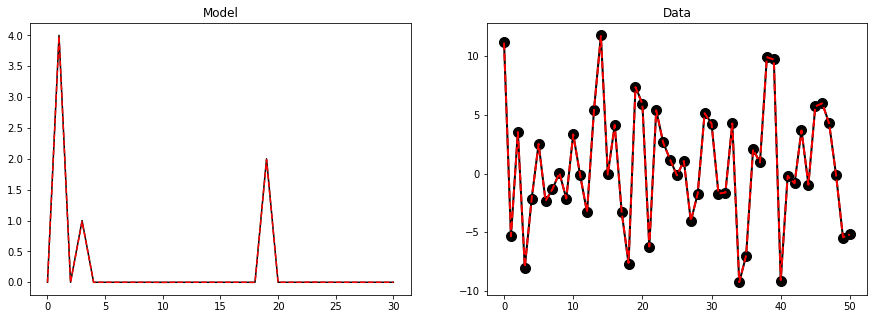

In [8]:
xfista, niterf, costf = FISTA(Lop, y, niter=20, eps=2., tol=1e-2, returninfo=True)
yfista = Lop * xfista

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(x, 'k', label='True')
axs[0].plot(xfista, '--r', label='Estimate')
axs[0].set_title('Model')

axs[1].plot(y, '.-k', ms=20, lw=2, label='True')
axs[1].plot(yfista, '--r', lw=2, label='Estimate')
axs[1].set_title('Data');

And SPGL1 for the problem with hard constraint

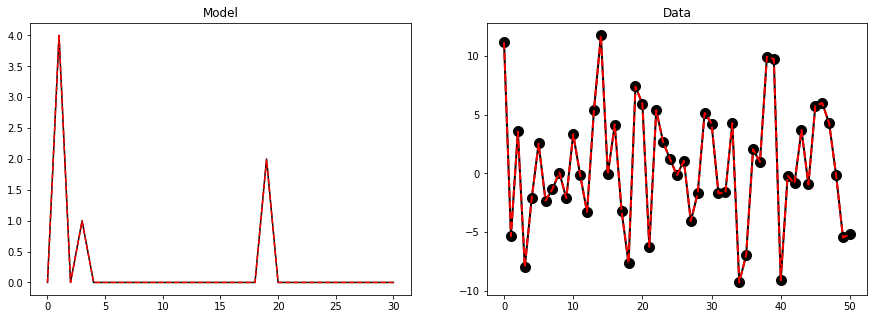

In [9]:
xspgl1 = SPGL1(Lop, y, sigma=1e-1, iter_lim=15, verbosity=0)[0]
yspgl1 = Lop * xspgl1

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(x, 'k', label='True')
axs[0].plot(xspgl1, '--r', label='Estimate')
axs[0].set_title('Model')

axs[1].plot(y, '.-k', ms=20, lw=2, label='True')
axs[1].plot(yspgl1, '--r', lw=2, label='Estimate')
axs[1].set_title('Data');

We can see that all of them have been succesfull. But which one costs us the most?

In [10]:
print('out-of-the-box with numerical gradients')
%timeit -r 3 -n 50 minimize(f, np.zeros(order+1), method='Powell', options=dict(maxiter=20))
%timeit -r 3 -n 50 minimize(f, np.zeros(order+1), method='BFGS', options=dict(maxiter=20))
%timeit -r 3 -n 50 minimize(f, np.zeros(order+1), method='CG', options=dict(maxiter=20))
%timeit -r 3 -n 50 minimize(f, np.zeros(order+1), method='L-BFGS-B', options=dict(maxiter=20))

print('out-of-the-box with analytical gradients')
%timeit -r 3 -n 50 minimize(f, np.zeros(order+1), jac=g, method='L-BFGS-B', options=dict(maxiter=20))

print('specialized')
%timeit -r 3 -n 50 FISTA(Lop, y, niter=20, eps=2., tol=1e-2, returninfo=False)
%timeit -r 3 -n 50 SPGL1(Lop, y, sigma=1e-1, iter_lim=15, verbosity=0)[0]

out-of-the-box with numerical gradients
343 ms ± 11.6 ms per loop (mean ± std. dev. of 3 runs, 50 loops each)
27.1 ms ± 1.64 ms per loop (mean ± std. dev. of 3 runs, 50 loops each)
42.1 ms ± 1.94 ms per loop (mean ± std. dev. of 3 runs, 50 loops each)
32.6 ms ± 585 µs per loop (mean ± std. dev. of 3 runs, 50 loops each)
out-of-the-box with analytical gradients
2.54 ms ± 255 µs per loop (mean ± std. dev. of 3 runs, 50 loops each)
specialized
3.79 ms ± 146 µs per loop (mean ± std. dev. of 3 runs, 50 loops each)
6.29 ms ± 490 µs per loop (mean ± std. dev. of 3 runs, 50 loops each)


Ok, not surprising!! If you throw yourself in the hand of out-of-the-box nonlinear solver (which does not know much about the structure of your problem other than how to numerically evaluate its cost function) you will pay the price. 

In this case, it took about 10 times longer to use the fastest ``scipy.optimize.minimize`` with numerical gradient compared to the same with analytical gradient or FISTA. SPGL1 in this case ended up being slower. 

This is not to say that `scipy.optimize.minimize` is a poor choice: it is a very good choice when you can't take advantage of any more specialized solvers for your cost function and/or you cannot write analytical gradients.

Finally it is important to remember that a L1 term to the cost function turns a simple linear problem into a nonlinear one, and common solvers like CG or LSQR cannot help. Nevertheless, there is a wealth of specific solvers in this area which should always be favoured to out-of-the-box nonlinear solvers when your original problem (LS term of cost function) is inherently linear.

In summary, this may look like a small, fairly useless toy example. There are however many problems where mixed L2-L1 norm cost functions are very helpful to create solutions that have a certain structure (either sparse or with blocky) and where you will definitely not like to spend time waiting for scipy.optimize.minimize to solve your cost function.

For some examples head over to:

- 1d interpolation: https://pylops.readthedocs.io/en/latest/tutorials/solvers.html#sphx-glr-tutorials-solvers-py
- 2d seismic interpolation: https://pylops.readthedocs.io/en/latest/tutorials/seismicinterpolation.html
- sparse least-squares migration: https://pylops.readthedocs.io/en/latest/tutorials/lsm.html